# Titanic Survival Kaggle Dataset

To import all necessary libraries for each stage.

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, cross_val_predict

## 1. Data Reading

In [91]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

The first step is to visually inspect both datasets.

In [92]:
df_train.head(10)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   
5            6         0       3   
6            7         0       1   
7            8         0       3   
8            9         1       3   
9           10         1       2   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   
5                                   Moran, Mr. James    male   NaN      0   
6                            McCarthy, Mr. Timothy J    male  54.0      0   
7                     Palsson, Master. Gosta Leonard    male   2.0      3   
8  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0      0   
9                Nasser, Mrs. Nicholas (Adele Achem)  female  14.0      1   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
5      0            330877   8.4583   NaN        Q  
6      0             17463  51.8625   E46        S  
7      1            349909  21.0750   NaN        S  
8      2            347742  11.1333   NaN        S  
9      0            237736  30.0708   NaN        C

In [93]:
df_test.head(10)

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   
5          897       3                    Svensson, Mr. Johan Cervin    male   
6          898       3                          Connolly, Miss. Kate  female   
7          899       2                  Caldwell, Mr. Albert Francis    male   
8          900       3     Abrahim, Mrs. Joseph (Sophie Halaut Easu)  female   
9          901       3                       Davies, Mr. John Samuel    male   

    Age  SibSp  Parch     Ticket     Fare Cabin Embarked  
0  34.5      0      0     330911   7.8292   NaN        Q  
1  47.0      1      0     363272   7.0000   NaN        S  
2  62.0      0      0     240276   9.6875   NaN        Q  
3  27.0      0      0     315154   8.6625   NaN        S  
4  22.0      1      1    3101298  12.2875   NaN        S  
5  14.0      0      0       7538   9.2250   NaN        S  
6  30.0      0      0     330972   7.6292   NaN        Q  
7  26.0      1      1     248738  29.0000   NaN        S  
8  18.0      0      0       2657   7.2292   NaN        C  
9  21.0      2      0  A/4 48871  24.1500   NaN        S

To be able to analyse the data as a whole and also to deal with NaN values I join both datasets.

We need to record any identification to be able to separate later both datasets, in this case PassengerId will work.

In [94]:
idx_train = df_train['PassengerId']
idx_test = df_test['PassengerId']
df_all = pd.concat([df_train, df_test],
                  axis = 0, sort = False)
df_all.set_index('PassengerId',
                drop = True,
                inplace = True)

With .info() method we can identify each feature type and also if there are NaN values.

In [97]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


We can see that the next variables have NaN values that we will need some action:
- Age = 263 NaN values.
- Fare = 1 NaN value.
- Cabin = 1014 NaN values.
- Embarked = 2 NaN values.

Now we can identify and describe each feature:

- Categorical features:
    - Pclass: Ordinal feature that shows the class of the ticket. 1: 1st Class, 2: 2nd Class, 3: 3rd Class
    - Sex: Categorical feature that identifies the genre.
    - Embarked: Categorical feature that identifies the port in which the passenger embarked.
    - Survived: Categorical feature that shows whether the passenger survived or not.

- Numerical features:
    - Age: Continuous numerical feature of the age of the passenger.
    - Fare: Continuous numerical feature of the cost of the ticket.
    - SibSp: Discrete numerical feature showing the amount of siblings and spouse in the boat.
    - Parch: Discrete numerical feature showing the amount of parents and children in the boat.

- Other features:
    - Name: Name of the passenger, we will use this feature to derive others features more useful.
    - Ticket: Ticket number of the passenger, we might use this feature to derive passengers that bought the ticket together.

Now we can use the method .describe() to get some statistical values for each feature.

In [98]:
df_all.describe(include = 'all')

Survived       Pclass                  Name   Sex          Age  \
count   891.000000  1309.000000                  1309  1309  1046.000000   
unique         NaN          NaN                  1307     2          NaN   
top            NaN          NaN  Connolly, Miss. Kate  male          NaN   
freq           NaN          NaN                     2   843          NaN   
mean      0.383838     2.294882                   NaN   NaN    29.881138   
std       0.486592     0.837836                   NaN   NaN    14.413493   
min       0.000000     1.000000                   NaN   NaN     0.170000   
25%       0.000000     2.000000                   NaN   NaN    21.000000   
50%       0.000000     3.000000                   NaN   NaN    28.000000   
75%       1.000000     3.000000                   NaN   NaN    39.000000   
max       1.000000     3.000000                   NaN   NaN    80.000000   

              SibSp        Parch    Ticket         Fare        Cabin Embarked  
count   1309.000000  1309.000000      1309  1308.000000          295     1307  
unique          NaN          NaN       929          NaN          186        3  
top             NaN          NaN  CA. 2343          NaN  C23 C25 C27        S  
freq            NaN          NaN        11          NaN            6      914  
mean       0.498854     0.385027       NaN    33.295479          NaN      NaN  
std        1.041658     0.865560       NaN    51.758668          NaN      NaN  
min        0.000000     0.000000       NaN     0.000000          NaN      NaN  
25%        0.000000     0.000000       NaN     7.895800          NaN      NaN  
50%        0.000000     0.000000       NaN    14.454200          NaN      NaN  
75%        1.000000     0.000000       NaN    31.275000          NaN      NaN  
max        8.000000     9.000000       NaN   512.329200          NaN      NaN

Just from this table we can extract some initial information:

- Survived is not completelly balanced, less than 40% of the people that we have data did survive.
- Pclass seems to have more of its values of 3rd class.
- There are 1307 unique names, composed by name, surname and title.
- The most frequent sex is male.
- The distribution of age seems quite normal, being the mean and median similar.
- Although there are people traveling with 8 siblings/spouse, the most common is to travel alone and after that to travel with just one sibling/spouse.
- Also it is very strange to travel with parents/children.
- Even though it is not as unique as Name feature, Ticket shows 929 unique values.
- Fare feature seems to be quite skewed to the left with a long tail to the right.
- Cabin feature is probably one of the most difficult to deal with because it is mostly filled with NaN values and unique values.
- Embarked seems to be quite unbalanced, where most of the people embarked at Southampton.

## 2. Data Cleaning

### 2.1. Sex

The feature sex does not have NaN values, but as they are strings it would be difficult to deal with it.

Therefore what we can do is convert it to a binary feature. 0 --> Male | 1 --> Female.

In [99]:
sex_dict = {'male': 0, 'female': 1}
df_all['Sex'] = df_all['Sex'].map(sex_dict)

### 2.2. Embarked

Embarked shows similar problem, so we can change a string feature to a numerical feature.

- S --> 0
- C --> 1
- Q --> 2

In [100]:
embarked_dict = {'S': 0, 'C': 1, 'Q': 2}
df_all['Embarked'] = df_all['Embarked'].map(embarked_dict)

### 2.3. Fare

As in this numerical continuous feature we have just one missing value, we can fill it with the meadian value.

To be a bit more accurate we can aggregate the values by Pclass as it is of key importance for ticket cost.

In [101]:
df_all['Fare'].fillna(df_all.groupby('Pclass')['Fare'].transform('median'),
                     inplace = True)

### 2.4. Age

Age feature also have missing values but in this case 263, it means that we need to do it with more care if we don't want to lose accuracy.

The appropriate method is to use the median and again aggregating the age in meaningful groups.

To find which features are appropriate to group the age we can use a heatmap with the correlation for each feature with the rest.

<AxesSubplot:>

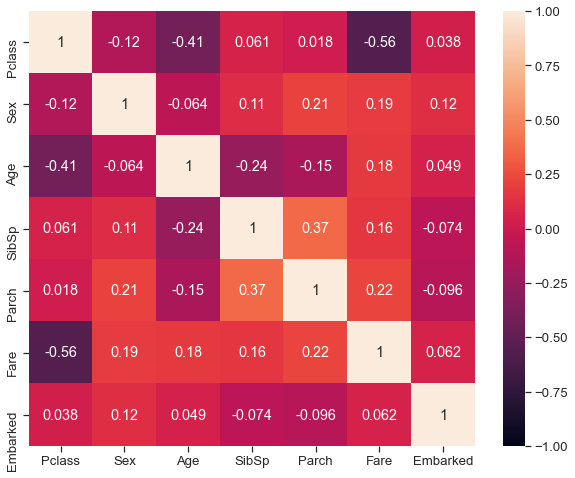

In [102]:
# First we delete the useless feateatures, name and ticket because the can't 
# be used to group age and also cabin a survive features because they have missing values.

df_age_corr = df_all.drop(['Name', 'Ticket','Cabin','Survived'],
                         axis = 1)

plt.figure(figsize = (10,8))
sns.set(font_scale = 1.2)
sns.set_style('ticks')

sns.heatmap(df_age_corr.corr(),
           vmin = -1,
           vmax = 1,
           annot = True)

We can identify that the features that shows some correlation with Age are:
- Pclass, strong inverse relation (the higher (1st, 2nd and 3rd) the class the higher the age.
- SibSp, it looks like that travel with spouse (SibSp = 1) might mean that you middle age or more. But if SibSp is higher than one usually you are child traveling with siblings.
- Parch, similar reasoning applies to Parch, just 1 or 2 means you are a child traveling with parents but more means that you have children. Both combined should be quite meaningful.
- Fare, this is very related to Pclass as the higher the class the higher the fare. To be able to group using fare we will need to bin the feature first.

In [103]:
df_age_corr['Fare_bin'] = pd.cut(df_age_corr['Fare'],
                                 5,
                                 labels = [0,1,2,3,4])

df_all['Age'].fillna(df_age_corr.groupby(['Pclass','SibSp','Parch','Fare_bin'])['Age'].transform('median'),
                     inplace = True)

We should confirm that all the missing values have been filled.

In [104]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   int64  
 4   Age       1307 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1309 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   float64
dtypes: float64(4), int64(4), object(3)
memory usage: 122.7+ KB


There are still two missing values. Let's inspect them one by one to understand why.

In [105]:
df_all[df_all['Age'].isnull()]

Survived  Pclass                            Name  Sex  Age  \
PassengerId                                                               
1234              NaN       3           Sage, Mr. John George    0  NaN   
1257              NaN       3  Sage, Mrs. John (Annie Bullen)    1  NaN   

             SibSp  Parch    Ticket   Fare Cabin  Embarked  
PassengerId                                                 
1234             1      9  CA. 2343  69.55   NaN       0.0  
1257             1      9  CA. 2343  69.55   NaN       0.0

The age of this two passengers are not filled because there is no more passengers with its combination of Pclass, SibSp, Parch and Fare. Therefore I will fill them just using Pclass and Fare to group and extract the data.

In [106]:
df_all['Age'].fillna(df_age_corr.groupby(['Pclass','Fare_bin'])['Age'].transform('median'),
                     inplace = True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    float64
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   int64  
 4   Age       1309 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1309 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   float64
dtypes: float64(4), int64(4), object(3)
memory usage: 122.7+ KB


Now age feature shows no more missing values.

#### 2.1.5. Embarked

There are just two missing values in embarked feature, initially I would use a similar approach as with Age, but being just two, let's inspect the lines to see if we can do it better.

In [107]:
df_all[df_all['Embarked'].isnull()]

Survived  Pclass                                       Name  Sex  \
PassengerId                                                                     
62                1.0       1                        Icard, Miss. Amelie    1   
830               1.0       1  Stone, Mrs. George Nelson (Martha Evelyn)    1   

              Age  SibSp  Parch  Ticket  Fare Cabin  Embarked  
PassengerId                                                    
62           38.0      0      0  113572  80.0   B28       NaN  
830          62.0      0      0  113572  80.0   B28       NaN

They happen to have the same ticket number, therefore they should have embarked from the same place. Looking for the names in internet, they did from Southampton, therefore I can replace NaN with a 0.

In [108]:
df_all['Embarked'].fillna(0, inplace = True)

#### 2.1.6. Cabin

The next feature to correct is embarked but it shows a 77% of missing values. First we should identify if it is worth to spend time on it.

I will start substituting NaN values with Other.

Also the cabin is compound by a letter and a number. The letter is likely to show the area in the boat and then the number should say specifically the room.

They area where you have the room seems that can be important to survive. Depends on how close it is from the deck or if it is closer to the sinking part of the boat, etc.

In [109]:
df_all['Cabin'].fillna('Other', inplace = True)
df_all['Cabin_Letter'] = df_all['Cabin'].str[0]

<AxesSubplot:title={'center':'% of People per Cabin Area'}, xlabel='Cabin_Letter', ylabel='Cabin'>

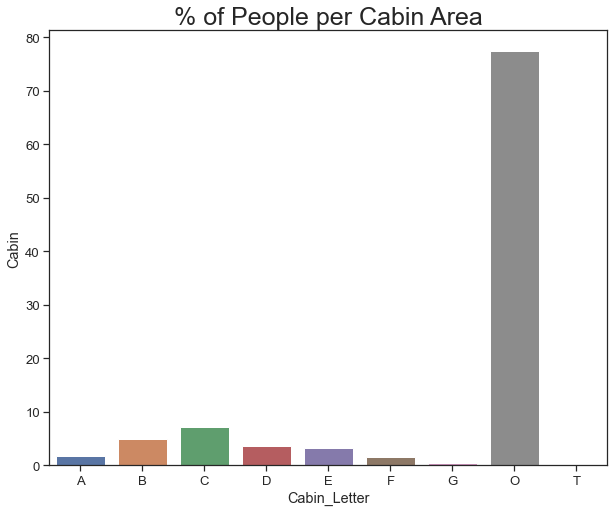

In [110]:
df_all_cabin_count = df_all.groupby(['Cabin_Letter']).count()
df_all_cabin_count = df_all_cabin_count['Cabin'].apply(lambda x: 100*x/df_all.shape[0])

df_all_cabin_count.index

plt.figure(figsize = (10,8))
sns.set(font_scale = 1.2)
sns.set_style('ticks')
plt.title('% of People per Cabin Area',
         fontdict = {'fontsize': 25})

sns.barplot(x = df_all_cabin_count.index,
           y = df_all_cabin_count)

As expected most of the passenger are in the missing cabin letter, almost none in G and T and then the other categories are more balanced. Although B and C are very predominant.

The fact that we have so little known values in general and also specifically for some of the categories that are less than 5 makes very difficult to fill the missing values with meaningful data.

From now I will keep the other category and check if cabin letter still provides some meaningful information.

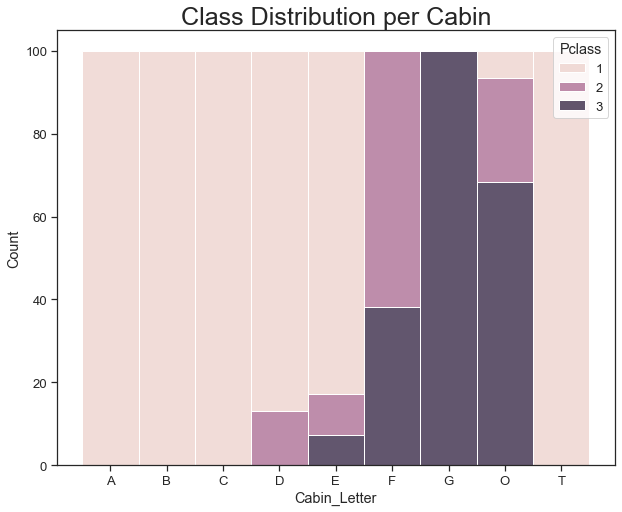

In [111]:
df_all_cabin_Pclass_count = df_all.groupby(['Cabin_Letter','Pclass']).count()
df_all_cabin_Pclass_count.reset_index(inplace = True)

Pclass_perc = []
for index, row in df_all_cabin_Pclass_count.iterrows():
    Pclass_perc.append(100*(row['Cabin']/df_all[df_all['Cabin_Letter'] == row['Cabin_Letter']]['Cabin_Letter'].count()))

df_all_cabin_Pclass_count['Cabin_Perc'] = Pclass_perc
    


plt.figure(figsize = (10,8))
sns.set(font_scale = 1.2)
sns.set_style('ticks')
plt.title('Class Distribution per Cabin',
         fontdict = {'fontsize': 25})

ax = sns.histplot(df_all_cabin_Pclass_count,
                 x = 'Cabin_Letter',
                 weights = 'Cabin_Perc',
                 hue = 'Pclass',
                 multiple = 'stack',
                 edgecolor = 'white')

We can identify how A, B and C and partially D and F are 1st class cabins, and then F and part of the unknown cabins are 2nd class. G is full 3rd class as well as the unknown part of cabin feature.

The most likely is that the 3rd class passengers were assigned to very crowded cabin areas with lack of registration.

So far we can find some value in cabin feature as it helps to distribute the passengers per class in the ship.

<AxesSubplot:title={'center':'Survived Distribution per Cabin'}, xlabel='Cabin_Letter', ylabel='Count'>

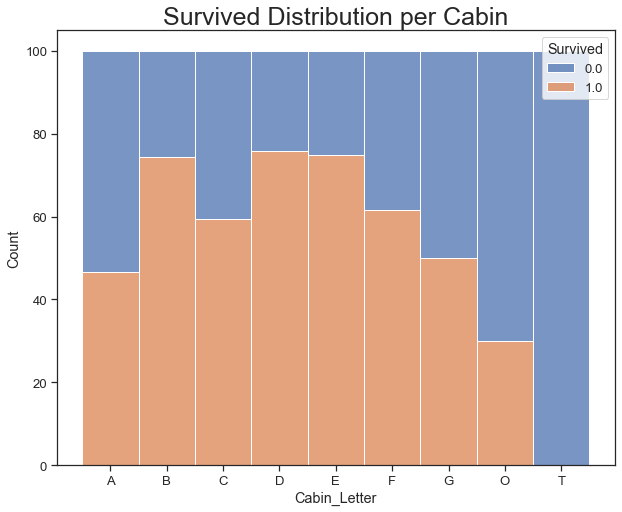

In [112]:
df_all_cabin_Survived_count = df_all.groupby(['Cabin_Letter','Survived']).count()
df_all_cabin_Survived_count.reset_index(inplace = True)

Survived_perc = []
for index, row in df_all_cabin_Survived_count.iterrows():
    Survived_perc.append(100*(row['Cabin']/df_all_cabin_Survived_count[df_all_cabin_Survived_count['Cabin_Letter'] == row['Cabin_Letter']]['Cabin'].sum()))

df_all_cabin_Survived_count['Cabin_Perc'] = Survived_perc
    


plt.figure(figsize = (10,8))
sns.set(font_scale = 1.2)
sns.set_style('ticks')
plt.title('Survived Distribution per Cabin',
         fontdict = {'fontsize': 25})

sns.histplot(df_all_cabin_Survived_count,
                 x = 'Cabin_Letter',
                 weights = 'Cabin_Perc',
                 hue = 'Survived',
                 multiple = 'stack',
                 edgecolor = 'white')

We can quickly see how some cabins are more likely to survive, possibly because it was easier to get to the deck or because they were far from the first sinking part of the boat.

Also seems that there is some correlation between Survived-Pclass-Cabin, which makes sense.

Looking to these results, we can leave the missing values as other as it still provides some useful information.

To work better with this feature I will map it to convert it to numerical feature.

In [113]:
cabin_dict = {'A': 0, 'B': 1, 'C': 2,'D': 3, 'E': 4, 'F': 5,'G': 6, 'O': 7, 'T': 7}
df_all['Cabin_Letter'] = df_all['Cabin_Letter'].map(cabin_dict)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Survived      891 non-null    float64
 1   Pclass        1309 non-null   int64  
 2   Name          1309 non-null   object 
 3   Sex           1309 non-null   int64  
 4   Age           1309 non-null   float64
 5   SibSp         1309 non-null   int64  
 6   Parch         1309 non-null   int64  
 7   Ticket        1309 non-null   object 
 8   Fare          1309 non-null   float64
 9   Cabin         1309 non-null   object 
 10  Embarked      1309 non-null   float64
 11  Cabin_Letter  1309 non-null   int64  
dtypes: float64(4), int64(5), object(3)
memory usage: 132.9+ KB


Now we can see how all the columns, but Survived, have no missing values.

The next step is to procceed to the exploration analysis.

## 3. Data Exploration

In this step we will try to get a better understanding of each feature and its relation with Survived mainly but also between each other.

First we can start by plotting a similar heatmap as before to identify strong correlations to study.

<AxesSubplot:>

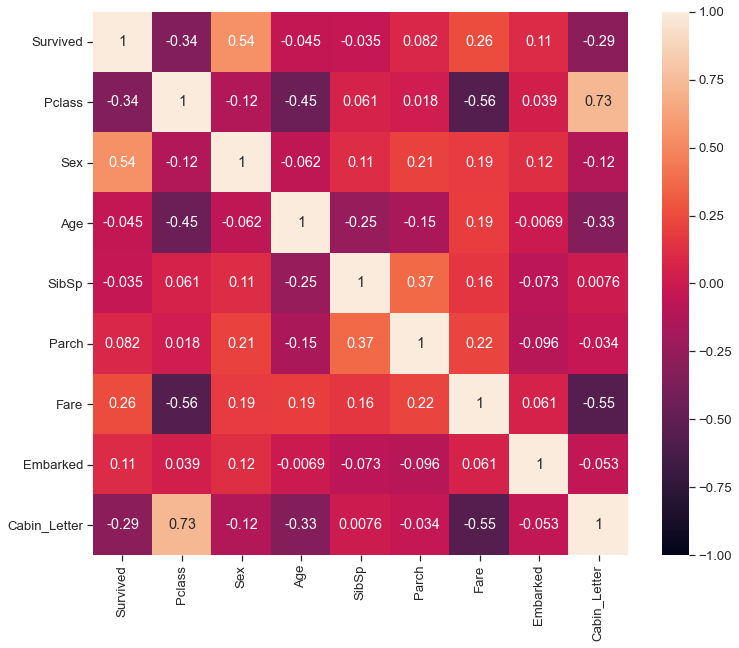

In [114]:
df_age_corr = df_all.drop(['Name', 'Ticket','Cabin'],
                         axis = 1)

plt.figure(figsize = (12,10))
sns.set(font_scale = 1.2)
sns.set_style('ticks')

sns.heatmap(df_age_corr.corr(),
           vmin = -1,
           vmax = 1,
           annot = True)

## 3.1. Pclass

Seems that Pclass has a good correlation with survived, age, fare and Cabin_Letter.

Lets inspect these relations.

<AxesSubplot:title={'center':'Survived Distribution per Passenger Class'}, xlabel='Pclass', ylabel='count'>

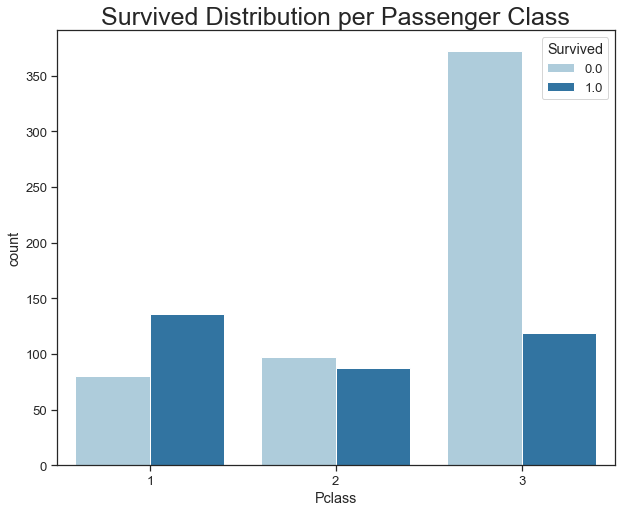

In [115]:
plt.figure(figsize = (10,8))
sns.set(font_scale = 1.2)
sns.set_style('ticks')
plt.title('Survived Distribution per Passenger Class',
         fontdict = {'fontsize': 25})

sns.countplot(data = df_all,
             x = 'Pclass',
             hue = 'Survived',
             palette = 'Paired')

We can clearly see that socio-economic position matters in order to survive.

1st class shows higher percentage of survived passenger, 2nd class is balanced but 3rd class shows a big difference being quite likely to die if you where in 3rd class.

Text(0.5, 0.98, 'Age Distribution per Passenger Class')

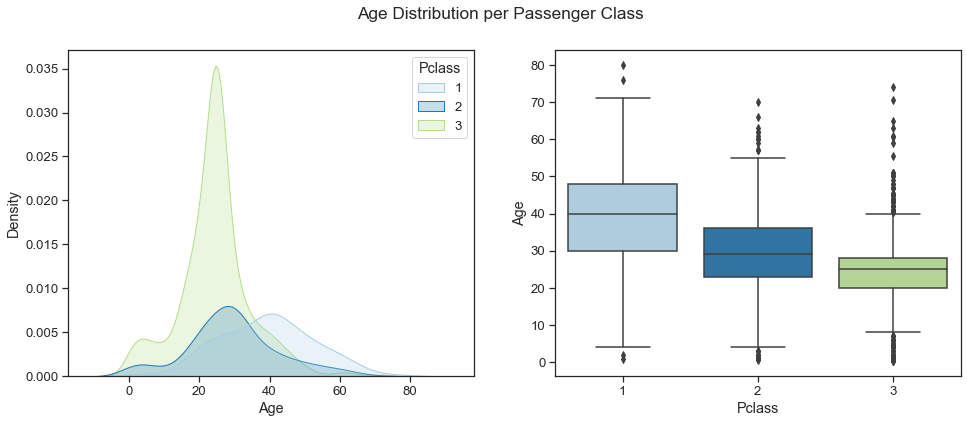

In [116]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16, 6)
sns.set(font_scale = 1.2)
sns.set_style('ticks')

ax1 = sns.kdeplot(data = df_all,
            x = 'Age',
            hue = 'Pclass',
            palette = 'Paired',
            shade = True,
            ax = ax1)

ax2 = sns.boxplot(data = df_all,
            x = 'Pclass',
            y = 'Age',
            palette = 'Paired')

fig.suptitle('Age Distribution per Passenger Class',
         fontdict = {'fontsize': 25})

We can see how the median of the first class is the highest with most of the people (25%-75%) between 30 and 50 years old. Not many outlayers, although the extreme quartiles covers almost the range because there are some children and elder people.

Second class is similar but with main body of the box slightly younger and the extremes not so spread.

The 3rd class as expected is the youngest one, but without children and babies and just elder people as outliers. Also the age range that covers is quite smaller.

All 3 follow a kind of normal distribution, being by far the 3rd class the most common one.

As summary, we can clearly see the relation between Age and Pclass.

Text(0.5, 0.98, 'Fare Distribution per Passenger Class')

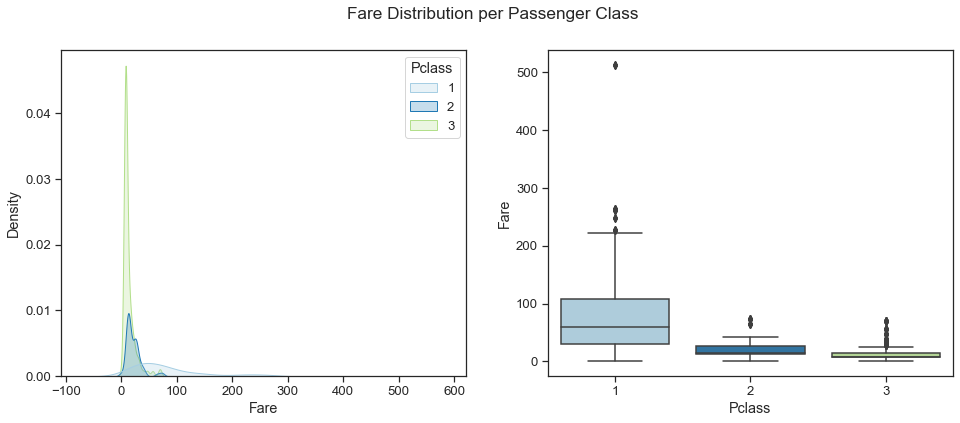

In [117]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16, 6)
sns.set(font_scale = 1.2)
sns.set_style('ticks')

ax1 = sns.kdeplot(data = df_all,
            x = 'Fare',
            hue = 'Pclass',
            palette = 'Paired',
            shade = True,
            ax = ax1)

ax2 = sns.boxplot(data = df_all,
            x = 'Pclass',
            y = 'Fare',
            palette = 'Paired')

fig.suptitle('Fare Distribution per Passenger Class',
         fontdict = {'fontsize': 25})

In this case 1st class shows the biggest range by far, 1st class tickets are the most expensive ones as expected. And also the most variable as they are luxury tickets I suppose they could be more customizable.

The second class shows to be cheaper than 1st and also more concentrated in lower cost with just some tickets falling in 1st class usual values.

The 3rd class is the closest to zero in terms of cost as expected.

All three classess shows quite skewed distribution, being the 3rd one with high skewness very close to zero.

Again we can confirm the correlation between Pclass and fare looking to the distribution.

Text(0.5, 0.98, 'Cabin Distribution per Passenger Class')

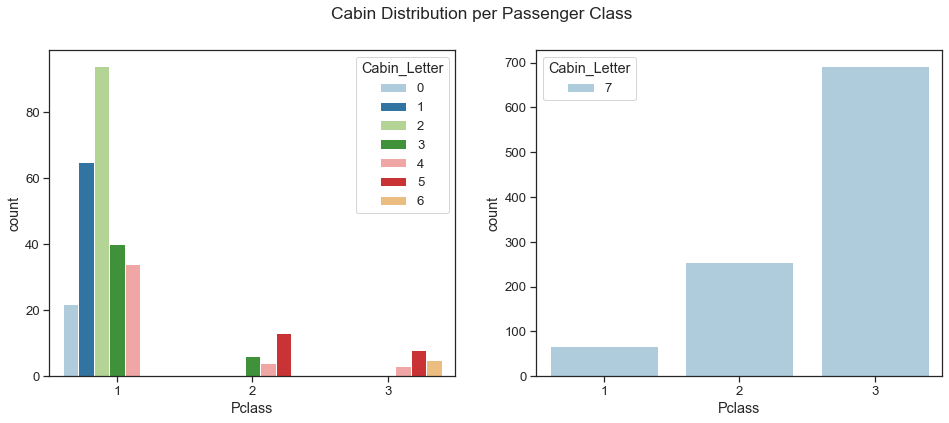

In [118]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16, 6)
sns.set(font_scale = 1.2)
sns.set_style('ticks')

ax1 = sns.countplot(data = df_all.drop(df_all[df_all['Cabin_Letter'] == 7].index, axis = 0),
             x = 'Pclass',
             hue = 'Cabin_Letter',
             palette = 'Paired',
             ax = ax1)

ax2 = sns.countplot(data = df_all.drop(df_all[df_all['Cabin_Letter'] != 7].index, axis = 0),
             x = 'Pclass',
             hue = 'Cabin_Letter',
             palette = 'Paired',
             ax = ax2)

fig.suptitle('Cabin Distribution per Passenger Class',
         fontdict = {'fontsize': 25})

The correlation factor calculated before is a bit misleading because the cabin named as "Other" has a big weight and it is mostly 3rd class.

But we still can see, as commented before, some relation of Pclass with the allocated cabin.

1st class had allocated mainly cabins from 0 to 2, being 3 and 4 mixed with 2nd class. The 3rd class was concentrated in cabin 5 and 6 and probably in the unknown ones.

## 3.2. Sex

Seems that Sex feature has a good correlation with survived, Parch and fare.

Lets inspect these relations.

<AxesSubplot:title={'center':'Survived Distribution per Passenger Sex'}, xlabel='Sex', ylabel='count'>

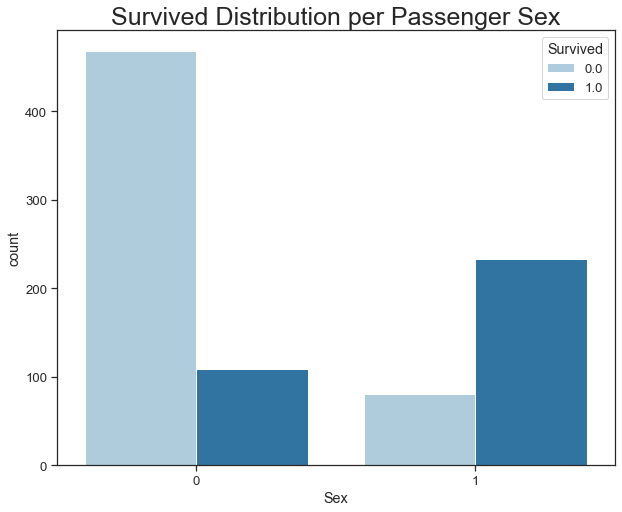

In [119]:
plt.figure(figsize = (10,8))
sns.set(font_scale = 1.2)
sns.set_style('ticks')
plt.title('Survived Distribution per Passenger Sex',
         fontdict = {'fontsize': 25})

sns.countplot(data = df_all,
             x = 'Sex',
             hue = 'Survived',
             palette = 'Paired')

The correlation between Sex and Survived is very strong.

The males survived in a very small percentaje, almost 5 times more died than survived.

In the case of females, it is just the opposite, more than double females survived than died.

<AxesSubplot:title={'center':'Parent and children Distribution per Passenger Sex'}, xlabel='Sex', ylabel='Parch'>

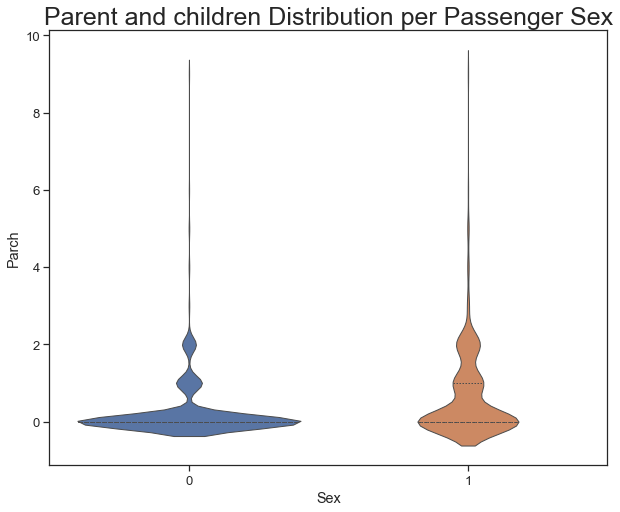

In [120]:
plt.figure(figsize = (10,8))
sns.set(font_scale = 1.2)
sns.set_style('ticks')
plt.title('Parent and children Distribution per Passenger Sex',
         fontdict = {'fontsize': 25})

sns.violinplot(data=df_all, x="Sex", y="Parch",
               split=True, inner="quart", linewidth=1)

Both sex travel mostly alone, with less frequency they travel with 1 or 2 parents/children and less frequently but mostly women travel with more than 2 parents/childre.

We can translate this information into:

- People traveling with 1-2 parents/children are a mix of adults with children and children with their parents. Although I guess more of the second option.
- In the case of more than 2, it is likely that are couples with children or a women with its children. Being more frequent the second option.

Text(0.5, 0.98, 'Fare Distribution per Passenger Sex')

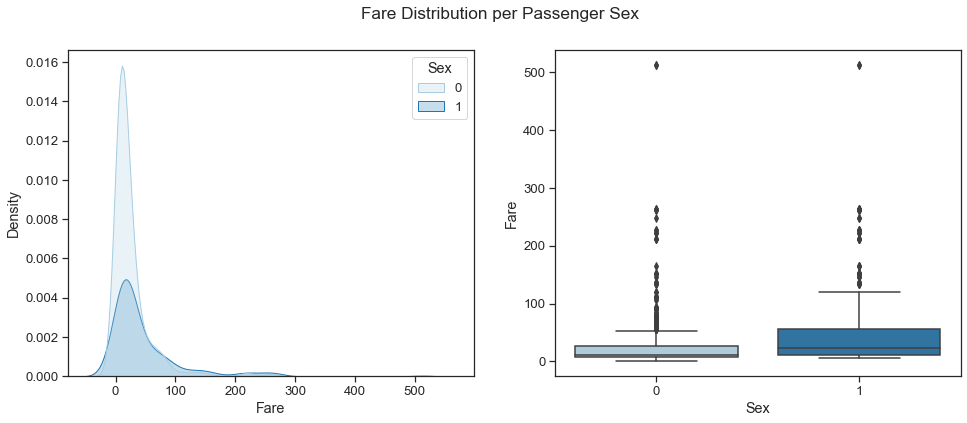

In [121]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16, 6)
sns.set(font_scale = 1.2)
sns.set_style('ticks')

ax1 = sns.kdeplot(data = df_all,
            x = 'Fare',
            hue = 'Sex',
            palette = 'Paired',
            shade = True,
            ax = ax1)

ax2 = sns.boxplot(data = df_all,
            x = 'Sex',
            y = 'Fare',
            palette = 'Paired')

fig.suptitle('Fare Distribution per Passenger Sex',
         fontdict = {'fontsize': 25})

The fare feature per sex shows a quite skewed distribution for both sex.

As expected male is much closer to zero as most of the males traveling where workers and poor people. Although there are high cost tickets for males but its percentage is very low.

Female passengers, even though it is skewed towards zero as well, it covers a higher range of ticket costs.

## 3.3. Age

Seems that Pclass has a good correlation with Pclass (already covered), SibSp, Parch, Fare and Cabin_Letter.

Lets inspect these relations.

Text(0.5, 0.98, 'SibSp Distribution per Passenger Age')

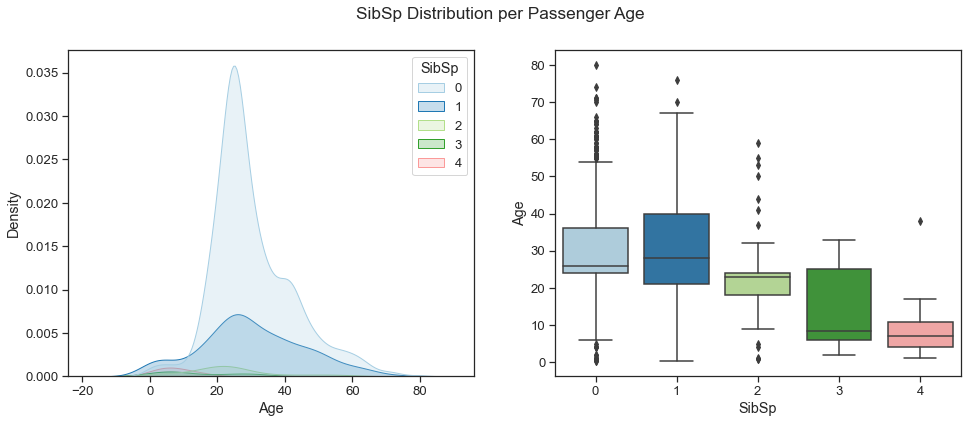

In [122]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16, 6)
sns.set(font_scale = 1.2)
sns.set_style('ticks')

ax1 = sns.kdeplot(data = df_all[df_all['SibSp'] < 5],
            x = 'Age',
            hue = 'SibSp',
            palette = 'Paired',
            shade = True,
            ax = ax1)

ax2 = sns.boxplot(data = df_all[df_all['SibSp'] < 5],
            x = 'SibSp',
            y = 'Age',
            palette = 'Paired')

fig.suptitle('SibSp Distribution per Passenger Age',
         fontdict = {'fontsize': 25})

To get a better visualization I have remove the values of SibSp over 4, as they are very little.

Similarly as Parch, most of the passenger travels alone and they are middle age, mostly between 25-35.

The next biggest group is passenger traveling with 1 SibSp, and we can understand that in this case they are mainly couples covering a bigger range than the people traveling alone. Although they are also middle age, 20-40. In this case there are some children traveling with just one sibling.

The passengers traveling with more than 1 Sibling/Spouse are younger, basically the higher the Sib/Sp the younger the passenger. Basically this groups are children and some young people traveling in family.

Text(0.5, 0.98, 'Parch Distribution per Passenger Age')

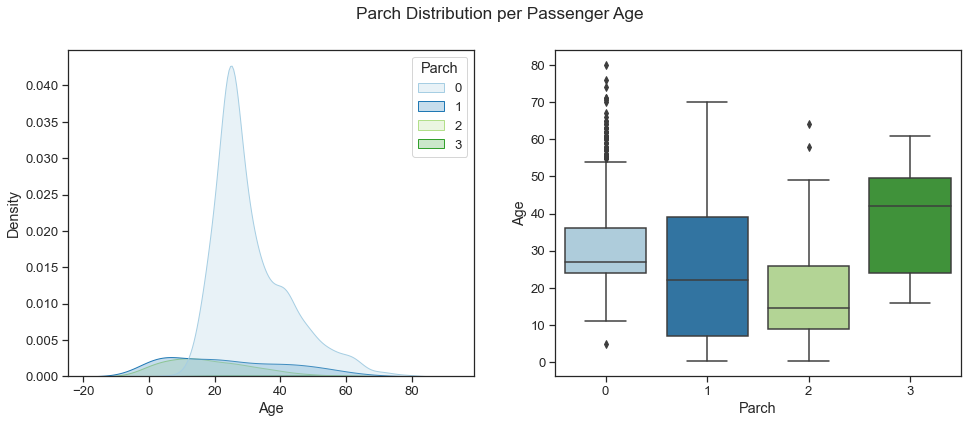

In [123]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16, 6)
sns.set(font_scale = 1.2)
sns.set_style('ticks')

ax1 = sns.kdeplot(data = df_all[df_all['Parch'] < 4],
            x = 'Age',
            hue = 'Parch',
            palette = 'Paired',
            shade = True,
            ax = ax1)

ax2 = sns.boxplot(data = df_all[df_all['Parch'] < 4],
            x = 'Parch',
            y = 'Age',
            palette = 'Paired')

fig.suptitle('Parch Distribution per Passenger Age',
         fontdict = {'fontsize': 25})

In this case I have removed Parch values under 4 because of the same reason as before.

Again, most of the people travels alone, and they are mostly between 25 and 35 years old.

The passengers traveling with just one parent or children covers a huge range, from less than 10 to more than 40. It means that there is a mix of single parents traveling with their child or viceversa.

The case of passengers traveling with 2 parents or children are most likely to be children with their parents or young people with children.

3 or more parents/children means mainly parents traveling with their children because the age range is mostly between 20 to 50.

<Figure size 1296x864 with 0 Axes>

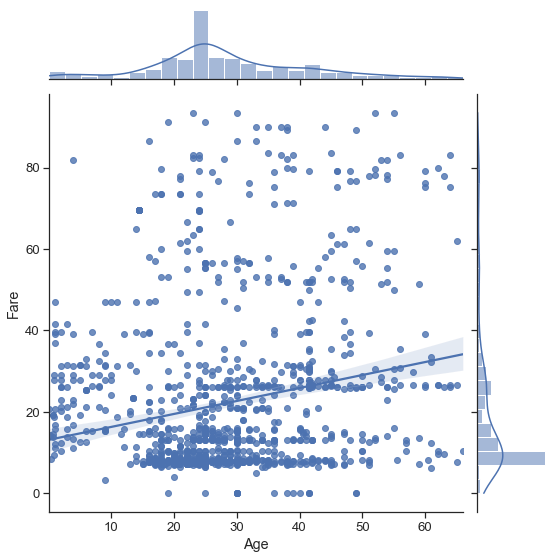

In [124]:
plt.figure(figsize = (18,12))
sns.set(font_scale = 1.2)
sns.set_style('ticks')

sns.jointplot(data = df_all[(df_all['Age'] < 70) & (df_all['Fare'] < 100)],
            x = 'Age',
            y = 'Fare',
            palette = 'Paired',
             height = 8,
             kind = 'reg')

I have removed some outliers, mainly in fare feature to get a better visualization. Otherwise a few points makes difficult to see actual distribution.

Comparing Age and fare it is quite difficult to find some insight.

We can appreciate a tendency of the increase of fare with the age. Which makes sense because the older the "higher" you can get social-economically.

The age feature follows a normal distribution centered in around 25-30 which also is logical and confirms previous comments.

Text(0.5, 0.98, 'Cabin Distribution per Passenger Age')

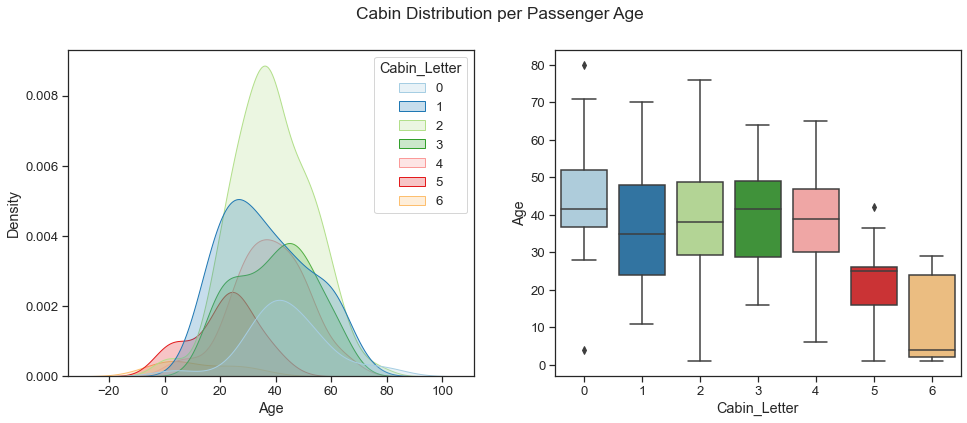

In [125]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16, 6)
sns.set(font_scale = 1.2)
sns.set_style('ticks')

ax1 = sns.kdeplot(data = df_all[df_all['Cabin_Letter'] != 7],
            x = 'Age',
            hue = 'Cabin_Letter',
            palette = 'Paired',
            shade = True,
            ax = ax1)

ax2 = sns.boxplot(data = df_all[df_all['Cabin_Letter'] != 7],
            x = 'Cabin_Letter',
            y = 'Age',
            palette = 'Paired')

fig.suptitle('Cabin Distribution per Passenger Age',
         fontdict = {'fontsize': 25})

I have removed the values of Other in Cabin because it makes difficult to read the graph and also it won't give us value as it comes from missing values.

As expected, the cabins occupied of first and second class are mainly of middle age passengers (30-50 approx.).

And the cabins expected to be for 3rd class shows younger passengers (workers) more concentrated between 20 to 30 years old.

We can see how almost all features give us socio-economic insights and are theoretically related one with each other.

## 3.4. SibSp

Seems that SibSp has a good correlation with age, fare and Parch.

Lets inspect these relations.

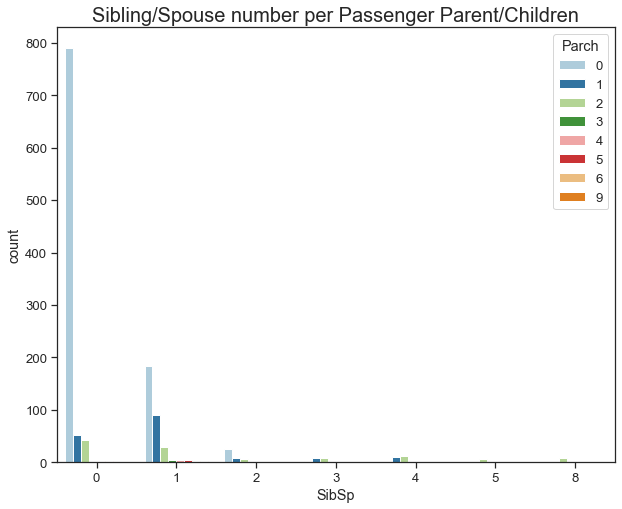

In [126]:
plt.figure(figsize = (10,8))
sns.set(font_scale = 1.2)
sns.set_style('ticks')
plt.title('Sibling/Spouse number per Passenger Parent/Children',
         fontdict = {'fontsize': 20})

sns.countplot(data = df_all,
             x = 'SibSp',
             hue = 'Parch',
             palette = 'Paired')
plt.legend(loc = 'upper right', title = 'Parch')

There is not much insight in this feature correlation, basically shows a high value because of the massive amount of people traveling alone.

Also that the families tend to be smal, a part from the passengers traveling alone, most of the passengers travel with a family size of 1-2.

## 3.5. Parch

Seems that Parch has a good correlation with Sex, age, fare and SibSp.

Lets inspect these relations.

Text(0.5, 0.98, 'Parch Distribution per Passenger Fare')

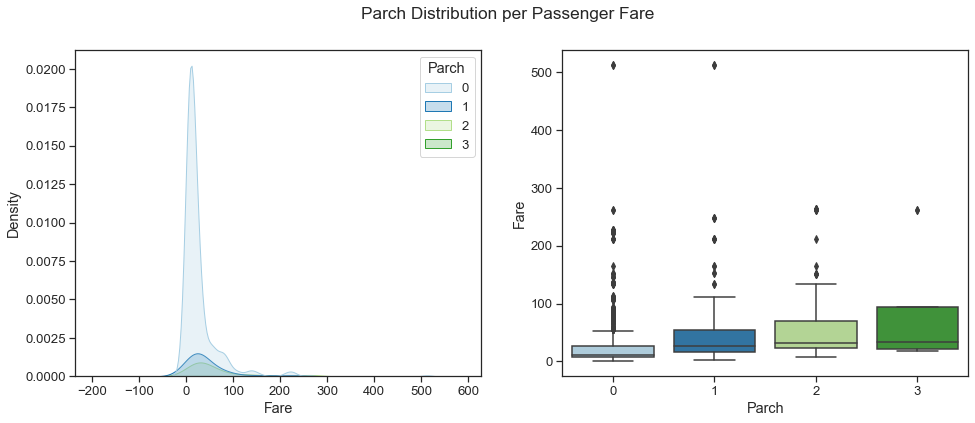

In [127]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16, 6)
sns.set(font_scale = 1.2)
sns.set_style('ticks')

ax1 = sns.kdeplot(data = df_all[df_all['Parch'] < 4],
            x = 'Fare',
            hue = 'Parch',
            palette = 'Paired',
            shade = True,
            ax = ax1)

ax2 = sns.boxplot(data = df_all[df_all['Parch'] < 4],
            x = 'Parch',
            y = 'Fare',
            palette = 'Paired')

fig.suptitle('Parch Distribution per Passenger Fare',
         fontdict = {'fontsize': 25})

As we have been commenting so far, most of the people travels alone. But it is interesting to see how as the amount of parents/children increases, so does the fare.

And not only in amount but also in spread. This might be because children's tickets are paid by their parents or because the people that travel with family can usually afford better tickets. I expect the workers to travel alone.

## 3.6. Fare

Seems that Fare has a good correlation with survived, Pclass, Sex, age, SibSp, Parch and Cabin_Letter.

Lets inspect these relations.

Text(0.5, 0.98, 'Cabin Distribution per Passenger Fare')

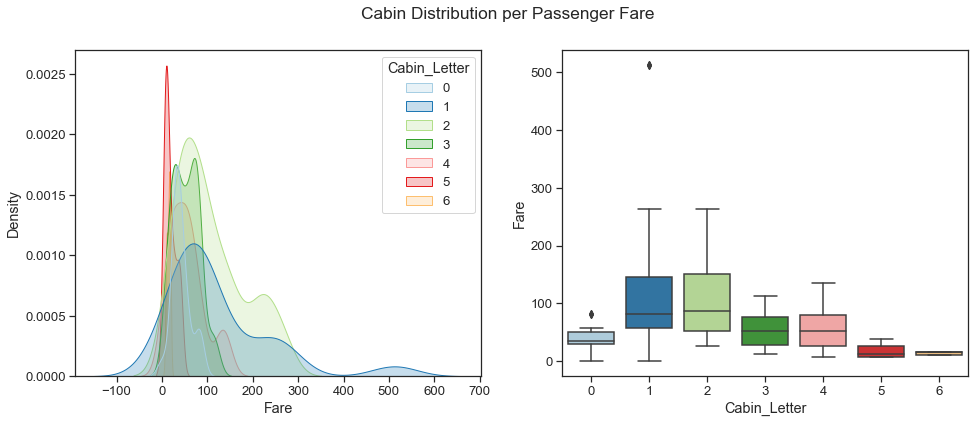

In [128]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16, 6)
sns.set(font_scale = 1.2)
sns.set_style('ticks')

ax1 = sns.kdeplot(data = df_all[df_all['Cabin_Letter'] != 7],
            x = 'Fare',
            hue = 'Cabin_Letter',
            palette = 'Paired',
            shade = True,
            ax = ax1)

ax2 = sns.boxplot(data = df_all[df_all['Cabin_Letter'] != 7],
            x = 'Cabin_Letter',
            y = 'Fare',
            palette = 'Paired')

fig.suptitle('Cabin Distribution per Passenger Fare',
         fontdict = {'fontsize': 25})

This relationship confirms what we were expecting, the cabins 5 and 6 that are composed of 3rd class mainly cost a fare very close to 0 in a highly skewed distribution.

The rest of Cabins of 1st and 2nd class show more variable fare cost not following an initial tendency. I suppose it is related with some extra items of each cabin, even though all are 1st class there are always addons to purchase.

## 3.7. Cabin

Seems that Cabin_Letter has a good correlation with survived, Pclass, age and fare.

Lets inspect these relations.

Text(0.5, 0.98, 'Survived Distribution per Passenger Cabin')

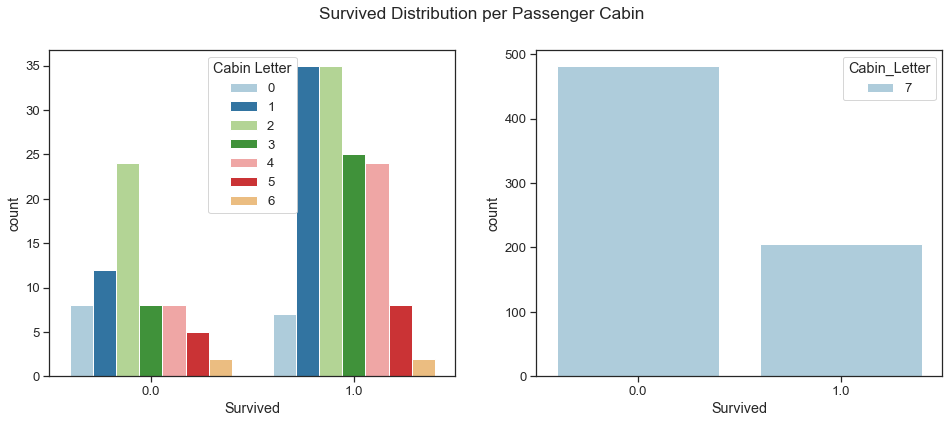

In [129]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16, 6)
sns.set(font_scale = 1.2)
sns.set_style('ticks')

ax1 = sns.countplot(data = df_all.drop(df_all[df_all['Cabin_Letter'] == 7].index, axis = 0),
             x = 'Survived',
             hue = 'Cabin_Letter',
             palette = 'Paired',
             ax = ax1)

ax1.legend(loc = 'upper center', title = 'Cabin Letter')

ax2 = sns.countplot(data = df_all.drop(df_all[df_all['Cabin_Letter'] != 7].index, axis = 0),
             x = 'Survived',
             hue = 'Cabin_Letter',
             palette = 'Paired',
             ax = ax2)

fig.suptitle('Survived Distribution per Passenger Cabin',
         fontdict = {'fontsize': 25})

As we have been seen previously first and second class have much better survival rate and this is translated to the cabins 0 to 4 that are mainly occupaid by those passenger classes.

It is interesting the case of the cabin 0 that shows a different tendecy, maybe even though it is full of 1st class passengers, it was not in the optimum location to survive.

It is also interesting to see that the 3rd class cabins 5-6 have a kind of balanced survival rate, it means (and we can confirm) that most of the non-survival passengers from 3rd class had unknown cabin details.

# 4. Feature Engineering

## 4.1 Title

The first feature we can create is a title feature.

From name feature we can extract the title and workout different groups that can add socio-economic insights.

In [130]:
df_all['Title'] = df_all['Name'].str.extract(', ([A-Za-z]+).')
df_all.groupby('Title')['Title'].count()

Title
Capt          1
Col           4
Don           1
Dona          1
Dr            8
Jonkheer      1
Lady          1
Major         2
Master       61
Miss        260
Mlle          2
Mme           1
Mr          757
Mrs         197
Ms            2
Rev           8
Sir           1
the           1
Name: Title, dtype: int64

We can see that most of the people are under the common titles (Master, Miss, Mr, Mrs). I will try to pack the uncommon ones in less categories.

- Capt, Col and Majo --> Military Rank
- Don --> Mr
- Dona --> Mrs
- Dr, Jonkheer, Lady, Sir, rev --> High class
- Mlle --> Miss
- Mme --> Mrs
- Ms --> Mrs
- the --> Mr

In [131]:
map_dict = {'Capt':'Soldier','Col':'Soldier','Don':'Mr','Dona':'Mrs','Dr':'Upper','Jonkheer':'Upper',
           'Lady':'Upper','Major':'Soldier','Mlle':'Miss','Mme':'Mrs','Ms':'Mrs','Rev':'Upper',
           'Sir':'Upper','the':'Mr','Master':'Master','Miss':'Miss','Mr':'Mr','Mrs':'Mrs'}
df_all['Title'] = df_all['Title'].map(map_dict)
df_all.groupby('Title')['Title'].count()

Title
Master      61
Miss       262
Mr         759
Mrs        201
Soldier      7
Upper       19
Name: Title, dtype: int64

## 4.2. Surname

From name feature we can also extract the surname.

It will not be used on the prediction model, but it will be useful to get more powerful features.

In [132]:
df_all['Surname'] = df_all['Name'].str.split(',')
df_all['Surname'] = df_all['Surname'].apply(lambda x: x[0])
df_all

Survived  Pclass  \
PassengerId                     
1                 0.0       3   
2                 1.0       1   
3                 1.0       3   
4                 1.0       1   
5                 0.0       3   
...               ...     ...   
1305              NaN       3   
1306              NaN       1   
1307              NaN       3   
1308              NaN       3   
1309              NaN       3   

                                                          Name  Sex   Age  \
PassengerId                                                                 
1                                      Braund, Mr. Owen Harris    0  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0   
3                                       Heikkinen, Miss. Laina    1  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0   
5                                     Allen, Mr. William Henry    0  35.0   
...                                                        ...  ...   ...   
1305                                        Spector, Mr. Woolf    0  25.0   
1306                              Oliva y Ocana, Dona. Fermina    1  39.0   
1307                              Saether, Mr. Simon Sivertsen    0  38.5   
1308                                       Ware, Mr. Frederick    0  25.0   
1309                                  Peter, Master. Michael J    0  16.0   

             SibSp  Parch              Ticket      Fare  Cabin  Embarked  \
PassengerId                                                                
1                1      0           A/5 21171    7.2500  Other       0.0   
2                1      0            PC 17599   71.2833    C85       1.0   
3                0      0    STON/O2. 3101282    7.9250  Other       0.0   
4                1      0              113803   53.1000   C123       0.0   
5                0      0              373450    8.0500  Other       0.0   
...            ...    ...                 ...       ...    ...       ...   
1305             0      0           A.5. 3236    8.0500  Other       0.0   
1306             0      0            PC 17758  108.9000   C105       1.0   
1307             0      0  SOTON/O.Q. 3101262    7.2500  Other       0.0   
1308             0      0              359309    8.0500  Other       0.0   
1309             1      1                2668   22.3583  Other       1.0   

             Cabin_Letter   Title        Surname  
PassengerId                                       
1                       7      Mr         Braund  
2                       2     Mrs        Cumings  
3                       7    Miss      Heikkinen  
4                       2     Mrs       Futrelle  
5                       7      Mr          Allen  
...                   ...     ...            ...  
1305                    7      Mr        Spector  
1306                    2     Mrs  Oliva y Ocana  
1307                    7      Mr        Saether  
1308                    7      Mr           Ware  
1309                    7  Master          Peter  

[1309 rows x 14 columns]

## 4.3. Male Survived

We have seen during the exploration that males have less survival rate than females.

We can combine sex feature with surname and survived features to create a new feature that shows if within the family there is any male that survived.

If the male in a family survived, it is more likely that the women or children survive.

In [133]:
def find_male_survived(surname):
    data = df_all[(df_all['Surname'] == surname) & (df_all['Sex'] == 0) & (df_all['Age'] > 14)]
    if data.shape[0] > 1:
        if data['Survived'].sum() > 0:
            return 1
        else:
            return 0
    else:
        return 0

df_all['Family_male_survived'] = df_all['Surname'].apply(lambda x: find_male_survived(x))
df_all[df_all['Family_male_survived'] == 1]

Survived  Pclass  \
PassengerId                     
14                0.0       3   
18                1.0       2   
53                1.0       1   
63                0.0       1   
66                1.0       3   
69                1.0       3   
120               0.0       3   
147               1.0       3   
156               0.0       1   
220               0.0       2   
225               1.0       1   
231               1.0       1   
250               0.0       2   
305               0.0       3   
335               1.0       1   
391               1.0       1   
429               0.0       3   
436               1.0       1   
487               1.0       1   
511               1.0       3   
542               0.0       3   
543               0.0       3   
551               1.0       1   
570               1.0       3   
571               1.0       2   
573               1.0       1   
582               1.0       1   
611               0.0       3   
646               1.0       1   
661               1.0       1   
693               1.0       3   
699               0.0       1   
710               1.0       3   
721               1.0       2   
736               0.0       3   
764               1.0       1   
794               0.0       1   
803               1.0       1   
814               0.0       3   
826               0.0       3   
827               0.0       3   
849               0.0       2   
851               0.0       3   
855               0.0       2   
858               1.0       1   
915               NaN       1   
1106              NaN       3   
1117              NaN       3   
1183              NaN       3   
1210              NaN       3   
1212              NaN       3   
1296              NaN       1   

                                                          Name  Sex   Age  \
PassengerId                                                                 
14                                 Andersson, Mr. Anders Johan    0  39.0   
18                                Williams, Mr. Charles Eugene    0  30.0   
53                    Harper, Mrs. Henry Sleeper (Myna Haxtun)    1  49.0   
63                                 Harris, Mr. Henry Birkhardt    0  45.0   
66                                    Moubarek, Master. Gerios    0  16.0   
69                             Andersson, Miss. Erna Alexandra    1  17.0   
120                          Andersson, Miss. Ellis Anna Maria    1   2.0   
147               Andersson, Mr. August Edvard ("Wennerstrom")    0  27.0   
156                                Williams, Mr. Charles Duane    0  51.0   
220                                         Harris, Mr. Walter    0  30.0   
225                               Hoyt, Mr. Frederick Maxfield    0  38.0   
231               Harris, Mrs. Henry Birkhardt (Irene Wallach)    1  35.0   
250                              Carter, Rev. Ernest Courtenay    0  54.0   
305                          Williams, Mr. Howard Hugh "Harry"    0  25.0   
335          Frauenthal, Mrs. Henry William (Clara Heinshei...    1  27.0   
391                                 Carter, Mr. William Ernest    0  36.0   
429                                           Flynn, Mr. James    0  25.0   
436                                  Carter, Miss. Lucile Polk    1  14.0   
487            Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)    1  35.0   
511                                   Daly, Mr. Eugene Patrick    0  29.0   
542                       Andersson, Miss. Ingeborg Constanzia    1   9.0   
543                          Andersson, Miss. Sigrid Elisabeth    1  11.0   
551                                Thayer, Mr. John Borland Jr    0  17.0   
570                                          Jonsson, Mr. Carl    0  32.0   
571                                         Harris, Mr. George    0  62.0   
573                           Flynn, Mr. John Irwin ("Irving")    0  36.0   
582          Thayer, Mrs. John Borland (Marian Longstreth M...    1  39.0 

## 4.4. Female with died child

In the same way we can compute which women passenger have in their family a died children.

At that time the women were the major responsible of taking care of the children, therefore if a woman have a children dead in his family it will be more likely for her to be dead.

In [134]:
def find_female_child_died(surname):
    data = df_all[((df_all['Surname'] == surname) & (df_all['Sex'] == 1) & (df_all['Age'] > 14)) | ((df_all['Surname'] == surname) & (df_all['Age'] < 14))]
    woman_child_survive = 0
    i = 0
    if data.shape[0] > 1:
        while ((i <= data.shape[0]-1) & (woman_child_survive == 0)):
            if data['Survived'].iloc[i] == np.nan:
                continue
            elif data['Survived'].iloc[i] == 0:
                woman_child_survive = 1
            i += 1
    else:
        return 0
    return woman_child_survive

df_all['Family_woman_child_died'] = df_all['Surname'].apply(lambda x: find_female_child_died(x))
df_all[df_all['Family_woman_child_died'] == 1]

Survived  Pclass  \
PassengerId                     
8                 0.0       3   
14                0.0       3   
17                0.0       3   
19                0.0       3   
25                0.0       3   
...               ...     ...   
1234              NaN       3   
1252              NaN       3   
1257              NaN       3   
1271              NaN       3   
1281              NaN       3   

                                                          Name  Sex   Age  \
PassengerId                                                                 
8                               Palsson, Master. Gosta Leonard    0   2.0   
14                                 Andersson, Mr. Anders Johan    0  39.0   
17                                        Rice, Master. Eugene    0   2.0   
19           Vander Planke, Mrs. Julius (Emelia Maria Vande...    1  31.0   
25                               Palsson, Miss. Torborg Danira    1   8.0   
...                                                        ...  ...   ...   
1234                                     Sage, Mr. John George    0  24.0   
1252                               Sage, Master. William Henry    0  14.5   
1257                            Sage, Mrs. John (Annie Bullen)    1  24.0   
1271                               Asplund, Master. Carl Edgar    0   5.0   
1281                               Palsson, Master. Paul Folke    0   6.0   

             SibSp  Parch    Ticket     Fare  Cabin  Embarked  Cabin_Letter  \
PassengerId                                                                   
8                3      1    349909  21.0750  Other       0.0             7   
14               1      5    347082  31.2750  Other       0.0             7   
17               4      1    382652  29.1250  Other       2.0             7   
19               1      0    345763  18.0000  Other       0.0             7   
25               3      1    349909  21.0750  Other       0.0             7   
...            ...    ...       ...      ...    ...       ...           ...   
1234             1      9  CA. 2343  69.5500  Other       0.0             7   
1252             8      2  CA. 2343  69.5500  Other       0.0             7   
1257             1      9  CA. 2343  69.5500  Other       0.0             7   
1271             4      2    347077  31.3875  Other       0.0             7   
1281             3      1    349909  21.0750  Other       0.0             7   

              Title        Surname  Family_male_survived  \
PassengerId                                                
8            Master        Palsson                     0   
14               Mr      Andersson                     1   
17           Master           Rice                     0   
19              Mrs  Vander Planke                     0   
25             Miss        Palsson                     0   
...             ...            ...                   ...   
1234             Mr           Sage                     0   
1252         Master           Sage                     0   
1257            Mrs           Sage                     0   
1271         Master        Asplund                     0   
1281         Master        Palsson                     0   

             Family_woman_child_died  
PassengerId                           
8                                  1  
14                                 1  
17                                 1  
19                                 1  
25                                 1  
...                              ...  
1234                               1  
1252                               1  
1257                               1  
1271                               1  
1281                               1  

[124 rows x 16 columns]

## 4.5. Family Size

It might be also useful for the model to have a combind feature of Parch + SibSp + 1 to represent the total size of the family.

In [135]:
df_all['Family_size'] = df_all.apply(lambda x: x['SibSp']+x['Parch']+1,
                                    axis = 1)
df_all['Alone'] = df_all['Family_size'].apply(lambda x: 1 if x == 1 else 0)
df_all

Survived  Pclass  \
PassengerId                     
1                 0.0       3   
2                 1.0       1   
3                 1.0       3   
4                 1.0       1   
5                 0.0       3   
...               ...     ...   
1305              NaN       3   
1306              NaN       1   
1307              NaN       3   
1308              NaN       3   
1309              NaN       3   

                                                          Name  Sex   Age  \
PassengerId                                                                 
1                                      Braund, Mr. Owen Harris    0  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...    1  38.0   
3                                       Heikkinen, Miss. Laina    1  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)    1  35.0   
5                                     Allen, Mr. William Henry    0  35.0   
...                                                        ...  ...   ...   
1305                                        Spector, Mr. Woolf    0  25.0   
1306                              Oliva y Ocana, Dona. Fermina    1  39.0   
1307                              Saether, Mr. Simon Sivertsen    0  38.5   
1308                                       Ware, Mr. Frederick    0  25.0   
1309                                  Peter, Master. Michael J    0  16.0   

             SibSp  Parch              Ticket      Fare  Cabin  Embarked  \
PassengerId                                                                
1                1      0           A/5 21171    7.2500  Other       0.0   
2                1      0            PC 17599   71.2833    C85       1.0   
3                0      0    STON/O2. 3101282    7.9250  Other       0.0   
4                1      0              113803   53.1000   C123       0.0   
5                0      0              373450    8.0500  Other       0.0   
...            ...    ...                 ...       ...    ...       ...   
1305             0      0           A.5. 3236    8.0500  Other       0.0   
1306             0      0            PC 17758  108.9000   C105       1.0   
1307             0      0  SOTON/O.Q. 3101262    7.2500  Other       0.0   
1308             0      0              359309    8.0500  Other       0.0   
1309             1      1                2668   22.3583  Other       1.0   

             Cabin_Letter   Title        Surname  Family_male_survived  \
PassengerId                                                              
1                       7      Mr         Braund                     0   
2                       2     Mrs        Cumings                     0   
3                       7    Miss      Heikkinen                     0   
4                       2     Mrs       Futrelle                     0   
5                       7      Mr          Allen                     0   
...                   ...     ...            ...                   ...   
1305                    7      Mr        Spector                     0   
1306                    2     Mrs  Oliva y Ocana                     0   
1307                    7      Mr        Saether                     0   
1308                    7      Mr           Ware                     0   
1309                    7  Master          Peter                     0   

             Family_woman_child_died  Family_size  Alone  
PassengerId                                               
1                                  0            2      0  
2                                  0            2      0  
3                                  0            1      1  
4                                  0            2      0  
5                                  0            1      1  
...                              ...          ...    ...  
1305                               0            1      1  
1306                               0            1      1  
1307                               0   

## 4.6. Scale and Dummy Variables

Now that we created all the features we should scale the continuous variables and encode the categorical ones.

The model will work better, faster as minimum, and probably will give us a better result.

In [136]:
df_all.drop(['Name','Ticket','Cabin','Surname'],
           axis = 1,
           inplace = True)

df_all = pd.get_dummies(df_all, 
                        columns = ['Pclass','Embarked','Cabin_Letter','Title'], 
                        prefix = ['Pclass','Embarked','Cabin_Letter','Title'])

df_all_without_survived = df_all.drop(['Survived','Sex','Pclass_1','Pclass_2','Pclass_3','Embarked_0.0',
                                  'Embarked_1.0','Embarked_2.0','Cabin_Letter_0','Cabin_Letter_1',
                                  'Cabin_Letter_2','Cabin_Letter_3','Cabin_Letter_4','Cabin_Letter_5',
                                  'Cabin_Letter_6','Cabin_Letter_7','Alone','Title_Master','Title_Miss',
                                  'Title_Mr','Title_Mrs','Title_Soldier','Title_Upper','Family_male_survived',
                                  'Family_woman_child_died'],
                                 axis = 1)
df_all_scaled_without_survived = preprocessing.scale(df_all_without_survived)

df_all_without_survived = pd.DataFrame(df_all_scaled_without_survived,
                                      columns = df_all_without_survived.columns,
                                      index = df_all.index)

df_all_with_dummy = df_all.loc[:,['Survived','Sex','Pclass_1','Pclass_2','Pclass_3','Embarked_0.0',
                                  'Embarked_1.0','Embarked_2.0','Cabin_Letter_0','Cabin_Letter_1',
                                  'Cabin_Letter_2','Cabin_Letter_3','Cabin_Letter_4','Cabin_Letter_5',
                                  'Cabin_Letter_6','Cabin_Letter_7','Alone','Title_Master','Title_Miss',
                                  'Title_Mr','Title_Mrs','Title_Soldier','Title_Upper','Family_male_survived',
                                  'Family_woman_child_died']]

df_all_scaled = pd.concat([df_all_with_dummy,df_all_without_survived], axis = 1)

df_all_scaled

Survived  Sex  Pclass_1  Pclass_2  Pclass_3  Embarked_0.0  \
PassengerId                                                              
1                 0.0    0         0         0         1             1   
2                 1.0    1         1         0         0             0   
3                 1.0    1         0         0         1             1   
4                 1.0    1         1         0         0             1   
5                 0.0    0         0         0         1             1   
...               ...  ...       ...       ...       ...           ...   
1305              NaN    0         0         0         1             1   
1306              NaN    1         1         0         0             0   
1307              NaN    0         0         0         1             1   
1308              NaN    0         0         0         1             1   
1309              NaN    0         0         0         1             0   

             Embarked_1.0  Embarked_2.0  Cabin_Letter_0  Cabin_Letter_1  ...  \
PassengerId                                                              ...   
1                       0             0               0               0  ...   
2                       1             0               0               0  ...   
3                       0             0               0               0  ...   
4                       0             0               0               0  ...   
5                       0             0               0               0  ...   
...                   ...           ...             ...             ...  ...   
1305                    0             0               0               0  ...   
1306                    1             0               0               0  ...   
1307                    0             0               0               0  ...   
1308                    0             0               0               0  ...   
1309                    1             0               0               0  ...   

             Title_Mrs  Title_Soldier  Title_Upper  Family_male_survived  \
PassengerId                                                                
1                    0              0            0                     0   
2                    1              0            0                     0   
3                    0              0            0                     0   
4                    1              0            0                     0   
5                    0              0            0                     0   
...                ...            ...          ...                   ...   
1305                 0              0            0                     0   
1306                 1              0            0                     0   
1307                 0              0            0                     0   
1308                 0              0            0                     0   
1309                 0              0            0                     0   

             Family_woman_child_died       Age     SibSp     Parch      Fare  \
PassengerId                                                                    
1                                  0 -0.541476  0.481288 -0.445000 -0.503176   
2                                  0  0.661502  0.481288 -0.445000  0.734809   
3                                  0 -0.240732 -0.479087 -0.445000 -0.490126   
4                                  0  0.435943  0.481288 -0.445000  0.383263   
5                                  0  0.435943 -0.479087 -0.445000 -0.487709   
...                              ...       ...       ...       ...       ...   
1305                               0 -0.315918 -0.479087 -0.445000 -0.487709   
1306                               0  0.736688 -0.479087 -0.445000  1.462069   
1307                               0  0.699095 -0.479087 -0.445000 -0.503176   
1308                               0 -0.315918 -0.479087 -0.445000 -0.487709   
1309                               0 -0.992593  0.481288  0.

In [143]:
df_train = df_all_scaled[df_all_scaled.index.isin(idx_train)]
df_test = df_all_scaled[df_all_scaled.index.isin(idx_test)].drop('Survived', axis = 1)

In [145]:
X_train = df_train.drop('Survived', axis = 1)
Y_train = df_train['Survived']

# Model Evaluation

I have already run through many iterations using some of the most common classification algorithm and I have got consistently the best result using XGBoost Classifier.

In this case I will use RepeatedStratifiedKFold to select the hyperparameters of the model.

In [146]:
#define the model
model = XGBClassifier()

#define the parameters to search
n_estimators = [200]#[100,500,1000,1500] Validated
learning_rate = [0.1]#[0.0001,0.001,0.01,0.1,1,10,100]
max_depth = [1]#range(1,10)#[3,8,12] Validated
min_child_weight = [1]#range(1,15)
gamma = [0.8]#np.arange(0,2,0.1)
subsample = [0.6]#np.arange(0,2,0.1)
colsample_bytree = [0.9]#np.arange(0,2,0.1)
scale_pos_weight = [0.9]#np.arange(0,2,0.1)
reg_alpha = [0.00001]#[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

#define grid search
grid = dict(n_estimators = n_estimators,
           learning_rate = learning_rate,
           max_depth = max_depth,
           min_child_weight = min_child_weight,
           gamma = gamma,
           subsample = subsample,
           colsample_bytree = colsample_bytree,
            scale_pos_weight = scale_pos_weight,
            reg_alpha = reg_alpha,
           use_label_encoder=[False])
cv = RepeatedStratifiedKFold(n_splits = 10, 
                             n_repeats = 3, 
                             random_state = 1)
grid_search = GridSearchCV(estimator = model,
                          param_grid = grid,
                          n_jobs = -1,
                          cv = cv,
                          scoring = 'accuracy',
                          error_score = 0,
                          verbose = 2)
grid_result = grid_search.fit(X_train, Y_train)

#summarize results
print('Best: %f using %s' % (grid_result.best_score_,
                            grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
results_dict = dict(means = means,
                  stds = stds,
                  params = params)

Fitting 30 folds for each of 1 candidates, totalling 30 fits
[16:14:21] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: 0.862310 using {'colsample_bytree': 0.9, 'gamma': 0.8, 'learning_rate': 0.1, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 200, 'reg_alpha': 1e-05, 'scale_pos_weight': 0.9, 'subsample': 0.6, 'use_label_encoder': False}


In [147]:
model = XGBClassifier(n_estimators = 200,
                       learning_rate = 0.1,
                       max_depth = 1,
                       min_child_weight = 1,
                       gamma = 0.8,
                       subsample = 0.6,
                       colsample_bytree = 0.9,
                       scale_pos_weight = 0.9,
                       reg_alpha = 0.00001,
                       eval_metric = 'logloss',
                       use_label_encoder=False).fit(X_train, Y_train)
model_result = cross_validate(model, X_train, Y_train, cv = 10,
                             scoring = ('accuracy', 'recall', 'f1','roc_auc'))
y_pred = cross_val_predict(model, X_train, Y_train, cv = 10)
pd.DataFrame(confusion_matrix(Y_train, y_pred))

0    1
0  502   47
1   77  265

The confusion matrix shows 502 classified as dead and 47 classified as dead when they are actualy alive.

In the case of passengers that are actually alive, the model found 265 correctly alive, but 77 that are actualy dead were found as survivors.

The false positives are probably our worst performance.

Let's see now the result in the test set:

In [149]:
Y_test = model.predict(df_test)

In [160]:
df_test_result = pd.concat([df_test.reset_index()['PassengerId'],pd.DataFrame(Y_test)],
                           axis = 1)
df_test_result.columns = ['PassengerId','Survived']
df_test_result

PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
..           ...       ...
413         1305         0
414         1306         1
415         1307         0
416         1308         0
417         1309         1

[418 rows x 2 columns]

To finalize let's check each feature importance to see which ones were more determinant.

<AxesSubplot:title={'center':'Feature Importances'}, xlabel='Importance', ylabel='Feature'>

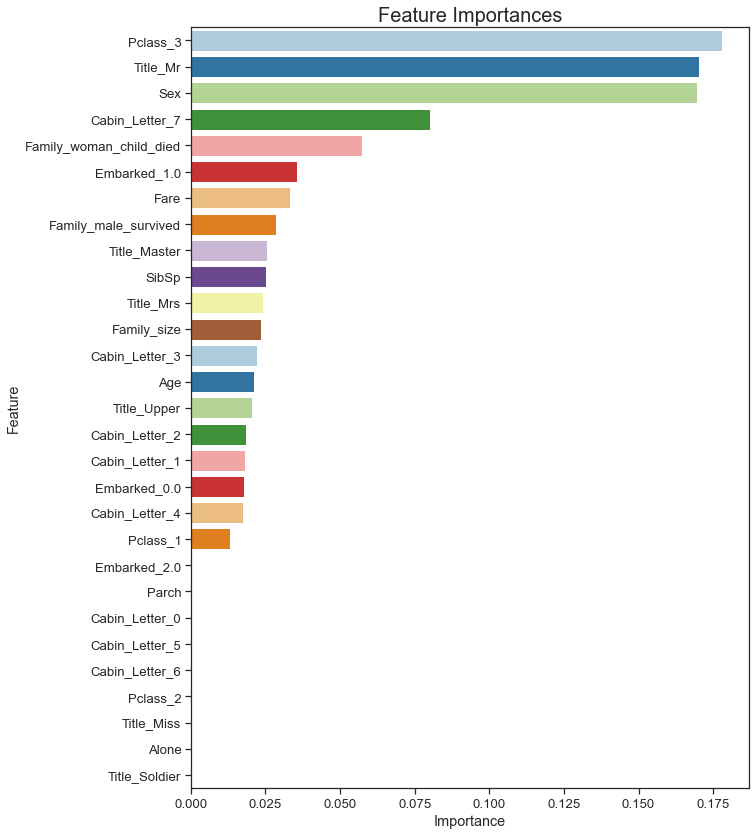

In [190]:
feature_names = pd.DataFrame(df_test.columns)
feature_importances_val = pd.DataFrame(model.feature_importances_)
feature_importances = pd.concat([feature_names, feature_importances_val], axis = 1)
feature_importances.columns = ['Feature', 'Importance']
feature_importances.sort_values('Importance',
                               inplace = True,
                               ascending = False)

plt.figure(figsize = (10,14))
sns.set(font_scale = 1.2)
sns.set_style('ticks')
plt.title('Feature Importances',
         fontdict = {'fontsize': 20})

sns.barplot(data = feature_importances,
             y = 'Feature',
             x = 'Importance',
             palette = 'Paired')